In [1]:
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CrowdCount
import torch
from tqdm import tqdm
%matplotlib inline

C:\Users\ojhag\AppData\Local\Temp\ipykernel_23132\2438601145.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
model = CrowdCount()

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [4]:
root = 'dataset/'

In [5]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_test]

In [6]:
#defining the image path
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

In [7]:
model = model.cuda()

In [8]:
checkpoint = torch.load('0model_best.pth.tar')

In [9]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [13]:
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

100%|██████████| 182/182 [00:39<00:00,  4.66it/s]

68.77317816346556


Predicted Count :  467


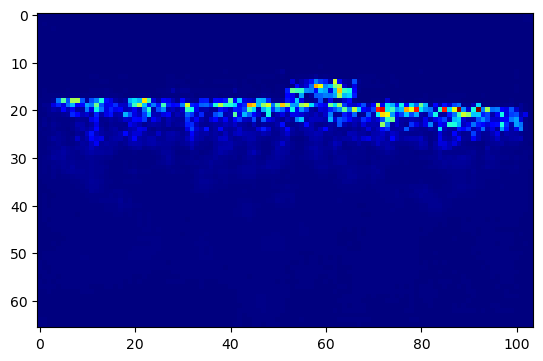

Original Count :  566


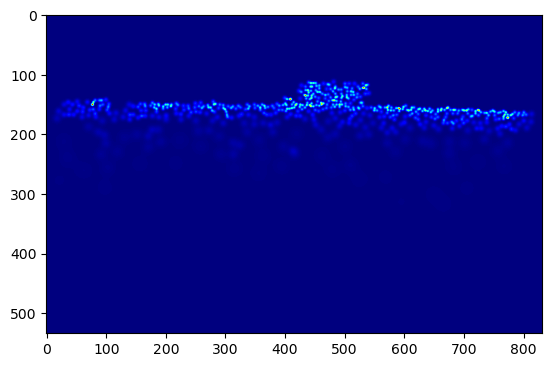

Original Image


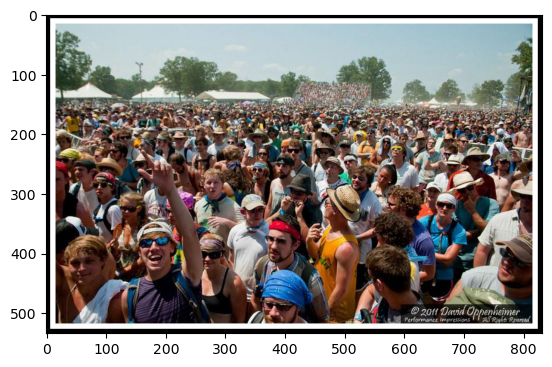

In [10]:
from matplotlib import cm as c
img = transform(Image.open('dataset/part_A_final/test_data/images/IMG_35.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('dataset/part_A_final/test_data/ground_truth/IMG_35.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('dataset/part_A_final/test_data/images/IMG_35.jpg'))
plt.show()

Predicted Count :  7


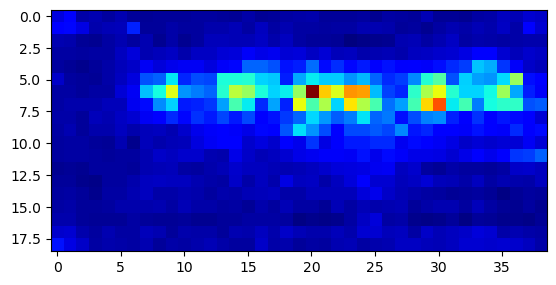

Original Image


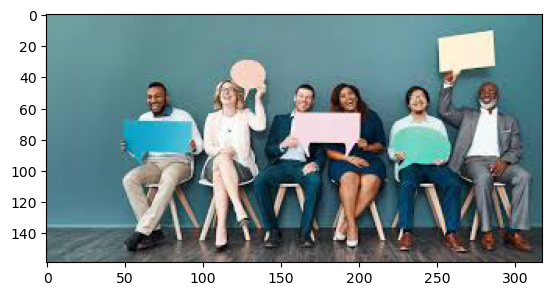

In [17]:
from matplotlib import cm as c
img = transform(Image.open('images.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()

print("Original Image")
plt.imshow(plt.imread('images.jpg'))
plt.show()

In [14]:
# Function to preprocess input frame
def preprocess(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224))  # Resize to match model input size
    frame = transform(frame)

    return frame

In [15]:
def predict(freme):

    img = preprocess(freme)
    output = model(img.unsqueeze(0))
    print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
    temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
    plt.imshow(temp,cmap = c.jet)
    plt.show()

In [16]:
# Capture video from webcam
cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    predict(frame)

In [19]:
import cv2
import numpy as np
import torch

# Initialize the camera
camera = cv2.VideoCapture(0)

while True:
    # Capture a frame from the camera
    ret, frame = camera.read()
    if not ret:
        print("failed to grab frame")
        break

    # Convert the frame to a tensor and run the model
    img = transform(frame).cuda()
    output = model(img.unsqueeze(0))

    print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))

    # Convert the output tensor to a numpy array and reshape it
    temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))

    # Normalize the values in the array to the range [0, 1]
    temp = (temp - temp.min()) / (temp.max() - temp.min())

    # Display the processed frame
    cv2.imshow("Output", frame)

    # Wait for a key press and exit if the 'q' key is pressed
    k = cv2.waitKey(1)
    if k%256 == ord('q'):
        print("Escape hit, closing...")
        break

# Release the camera and close the window
camera.release()
cv2.destroyAllWindows()

Predicted Count :  16
Predicted Count :  17
Predicted Count :  15
Predicted Count :  17
Predicted Count :  16
Predicted Count :  15
Predicted Count :  16
Predicted Count :  18
Predicted Count :  18
Predicted Count :  16
Predicted Count :  16
Predicted Count :  16
Predicted Count :  18
Predicted Count :  18
Predicted Count :  15
Predicted Count :  16
Predicted Count :  18
Predicted Count :  16
Predicted Count :  16
Predicted Count :  18
Predicted Count :  16
Predicted Count :  16
Predicted Count :  17
Predicted Count :  18
Predicted Count :  15
Predicted Count :  16
Predicted Count :  17
Predicted Count :  16
Predicted Count :  17
Predicted Count :  18
Predicted Count :  16
Predicted Count :  16
Predicted Count :  15
Predicted Count :  17
Predicted Count :  16
Predicted Count :  15
Predicted Count :  15
Predicted Count :  17
Predicted Count :  15
Predicted Count :  16
Predicted Count :  15
Predicted Count :  16
Predicted Count :  14
Predicted Count :  16
Predicted Count :  18
Predicted 